In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import os
from tqdm import tqdm
import glob
import shutil
from collections import namedtuple

## Functions

In [4]:
def histoplot(var, xlabel, ylabel, bins=100, figsize=(4,4), title=""):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    h = plt.hist(var,bins)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return h[0],h[1]

In [5]:
def event_ekin(df):
    grdf = df.groupby('event_id')
    ekin = grdf['kin_energy'].sum()
    return ekin

In [6]:
def event_size(df):
    return len(np.unique(df.event_id))

In [7]:
def select_gammas_interact_in_crystal(df):
    grdf = df.groupby('event_id')
    return grdf.filter(lambda x: ((x.mother_id == 0) & (x['final_volume'] == 'CRYSTAL')).any() )



In [8]:
def concat_df(file_paths, start=0, end=10):
    DF =[]
    for file in file_paths[start:end]:
        gammas = pd.read_hdf(file,"MC/particles")
        DF.append(gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1))
                      
    return pd.concat(DF, axis=0)

In [9]:
def filter_df(file_paths, start=0, end=10, eth=0.001, lmax=60, prnt=10):
    """
    Filter and reduce the DF
    1. Select events in which gammas interact in crystal
    2. Remove primary gammas
    3. Impose threshold in energy and length
    4. Drop columns not needed, create columns needed for barycenter and rename fields
    5. Concat files
    """

    DF =[]
    XF=[]
    for i, file in tqdm(enumerate(file_paths[start:end])):
    #for i, file in enumerate(file_paths[start:end]):
        if i%prnt == 0:
            print(f"Reading data frame {i}")
        gammas = pd.read_hdf(file,"MC/particles")
        gdf1 = gammas.drop(['initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
                 'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
                'final_proc', 'final_t'], axis=1)

        if i%prnt == 0:
            print(f"Select events in which gammas interact in crystal:")
        gdf2 = select_gammas_interact_in_crystal(gdf1)
        
        if i%prnt == 0:
            print(f"Remove primary gammas: ")
        gdf3 = gdf2[gdf2['mother_id'] != 0]

        if i%prnt == 0:
            print(f"Remove particles not coming from primaryC") 
        grdf = gdf3.groupby('event_id')
        gdf4 = grdf.apply(lambda x: x[x['mother_id'] == 1]).reset_index(drop=True)

        if i%prnt == 0:
            print(f"Impose threshold in energy and length") 
        gdf5 = gdf4[(gdf4['kin_energy'] >eth) & (gdf4.length<lmax)]

        if i%prnt == 0:
            print(f"Drop some extra columns and rename fields") 
        gdf6 = gdf5.drop(['final_x', 'final_y', 'final_z', 'length',
                  'primary', 'mother_id', 'initial_volume', 'final_volume'], axis=1)

        gdf6.rename(columns={'initial_x': 'x'}, inplace=True)
        gdf6.rename(columns={'initial_y': 'y'}, inplace=True)
        gdf6.rename(columns={'initial_z': 'z'}, inplace=True)
        #gdf6.rename(columns={'kin_energy': 'E'}, inplace=True)

        XF.append(event_size(gdf6)/event_size(gammas))
        DF.append(gdf6)

    print(f"now concat:") 
    df = pd.concat(DF, axis=0)
    xf = np.mean(np.array(XF))
    return df, xf


In [40]:
eval("1==1")

True

In [41]:
def efilter(ecut, op=">"):
    def filter_ekin(group):
        if op == ">":
            return group[group['kin_energy'] > ecut]
        elif op == "=":
            return group[group['kin_energy'] == ecut]
        elif op == "<":
            return group[group['kin_energy'] < ecut]
        else:
            print("unknown operation")
            return False
    return filter_ekin
    

In [47]:
def get_folder_out(folder_h5, lbl="phe"):
    ns = folder_h5.split("_")[:-1] # remove "h5" or "NX"
    ns.append(lbl)
    return '_'.join(ns)

In [12]:
def write_images(events, ifolder, ofolder, 
                 events_per_file, got_positions, crystal_width, sipm_width, h5fpfx):
   
    events["file_id"] = (events["event_id"] // events_per_file).astype(int)

    for group_name, group_data in tqdm(events.groupby("file_id")):
        nexus_file = f"{ifolder}/{h5fpfx}.{group_name}.h5"
        print(f"reading nexus file = {nexus_file}")

        if not got_positions:
            monolithic_csi_positions = pd.read_hdf(nexus_file, "MC/sns_positions")
            sensor_ids = np.array(monolithic_csi_positions['sensor_id'])
            pos_dict = {}
            for sensor_id in sensor_ids:
                pos_dict[sensor_id] = {'x': int((monolithic_csi_positions.query(f"sensor_id=={sensor_id}")['x'].iloc(0)[0]+crystal_width/2)/sipm_width),
                                       'y': int((monolithic_csi_positions.query(f"sensor_id=={sensor_id}")['y'].iloc(0)[0]+crystal_width/2)/sipm_width)}
            got_positions = True

        sns_response = pd.read_hdf(nexus_file, "MC/sns_response")
        this_image_events = group_data["event_id"] 
        sns_response = sns_response[sns_response["event_id"].isin(this_image_events)]

        events = np.unique(sns_response['event_id'])
        images = np.zeros((events.shape[0],crystal_width//sipm_width,crystal_width//sipm_width))
        ev_wfs = sns_response.groupby("event_id")
        j = 0
        for _, ev_wf in ev_wfs:
            average_position = ev_wf.groupby("sensor_id").sum()
            for sid in average_position.index:
                position_x = pos_dict[sid]['x']
                position_y = pos_dict[sid]['y']
                images[j, position_x, position_y] += average_position['charge'][sid]
            j += 1

        print(f"saving file = {ofolder}/images_{group_name}.npy")

        np.save(f"{ofolder}/images_{group_name}.npy", images.astype(np.float32))

## Globals

In [13]:
path_to_data=os.environ['MONOLITH_DATA'] 

In [14]:
npr=10
eth = 0.001 # in keV
lmax = 60 # in mm

## Code

In [15]:
dir = os.path.join(path_to_data,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5")

In [16]:
# Define the pattern to match all .txt files in the 'documents' directory
pattern = f'{dir}/*.h5'

# Use glob to find all files matching the pattern
file_paths = glob.glob(pattern)



In [17]:
gdf, xdf = filter_df(file_paths, start=0, end=len(file_paths), eth=0.001, lmax=60, prnt=10)

0it [00:00, ?it/s]

Reading data frame 0
Select events in which gammas interact in crystal:
Remove primary gammas: 
Remove particles not coming from primaryC


1it [00:03,  3.38s/it]

Impose threshold in energy and length
Drop some extra columns and rename fields


10it [00:23,  2.23s/it]

Reading data frame 10
Select events in which gammas interact in crystal:
Remove primary gammas: 
Remove particles not coming from primaryC


11it [00:25,  2.28s/it]

Impose threshold in energy and length
Drop some extra columns and rename fields


20it [00:46,  2.21s/it]

Reading data frame 20
Select events in which gammas interact in crystal:
Remove primary gammas: 
Remove particles not coming from primaryC


21it [00:48,  2.29s/it]

Impose threshold in energy and length
Drop some extra columns and rename fields


30it [01:11,  2.62s/it]

Reading data frame 30
Select events in which gammas interact in crystal:
Remove primary gammas: 
Remove particles not coming from primaryC


31it [01:13,  2.53s/it]

Impose threshold in energy and length
Drop some extra columns and rename fields


40it [01:34,  2.31s/it]

Reading data frame 40
Select events in which gammas interact in crystal:
Remove primary gammas: 
Remove particles not coming from primaryC


41it [01:37,  2.55s/it]

Impose threshold in energy and length
Drop some extra columns and rename fields


50it [02:01,  2.58s/it]

Reading data frame 50
Select events in which gammas interact in crystal:
Remove primary gammas: 
Remove particles not coming from primaryC


51it [02:04,  2.59s/it]

Impose threshold in energy and length
Drop some extra columns and rename fields


60it [02:29,  2.71s/it]

Reading data frame 60
Select events in which gammas interact in crystal:
Remove primary gammas: 
Remove particles not coming from primaryC


61it [02:31,  2.68s/it]

Impose threshold in energy and length
Drop some extra columns and rename fields


70it [02:54,  2.41s/it]

Reading data frame 70
Select events in which gammas interact in crystal:
Remove primary gammas: 
Remove particles not coming from primaryC


71it [02:56,  2.39s/it]

Impose threshold in energy and length
Drop some extra columns and rename fields


80it [03:18,  2.43s/it]

Reading data frame 80
Select events in which gammas interact in crystal:
Remove primary gammas: 
Remove particles not coming from primaryC


81it [03:20,  2.41s/it]

Impose threshold in energy and length
Drop some extra columns and rename fields


90it [03:43,  2.55s/it]

Reading data frame 90
Select events in which gammas interact in crystal:
Remove primary gammas: 
Remove particles not coming from primaryC


91it [03:45,  2.48s/it]

Impose threshold in energy and length
Drop some extra columns and rename fields


100it [04:06,  2.47s/it]

now concat:


In [18]:
gdf.head(npr)

,event_id,particle_id,particle_name,x,y,z,initial_t,kin_energy,creator_proc
0,680002,2,e-,17.471272,-21.407799,15.194095,0.070294,0.212338,compt
1,680002,25621,e-,16.308014,-8.935721,20.914680,0.116228,0.002909,compt
2,680002,26109,e-,15.823273,-6.602371,22.563520,0.125894,0.003268,phot
3,680002,26108,e-,15.823273,-6.602371,22.563520,0.125894,0.003892,phot
4,680002,26107,e-,15.823273,-6.602371,22.563520,0.125894,0.025294,phot
5,680002,26106,e-,15.823273,-6.602371,22.563520,0.125894,0.258608,phot
6,680005,3,e-,6.790020,7.181014,32.762108,0.128651,0.005044,compt
7,680005,2,e-,6.790020,7.181014,32.762108,0.128651,0.222331,compt
8,680005,27589,e-,15.265637,4.257829,35.750702,0.160174,0.080053,compt
9,680005,37070,e-,18.203693,2.432415,30.927778,0.179971,0.003284,phot


In [19]:
print(f" fraction of events passing cuts = {xdf}")

 fraction of events passing cuts = 0.6565714554713172


### XYZ distributions

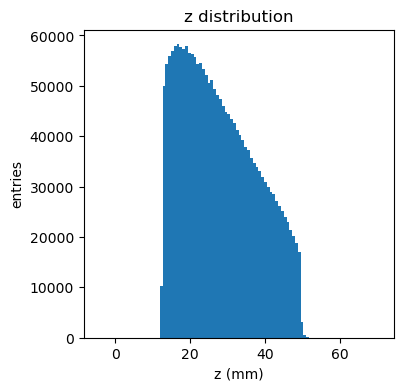

In [20]:
b, e = histoplot(gdf.z, "z (mm)", "entries", bins=100, figsize=(4,4),
                title="z distribution")

In [21]:
zmin = np.ceil(e[0])
zmax = np.floor(e[-1])
dz = zmax - zmin
print(f"zmax = {zmax:.2f}, zmin = {zmin:.2f}, dz = {dz:.2f}")

zmax = 70.00, zmin = -4.00, dz = 74.00


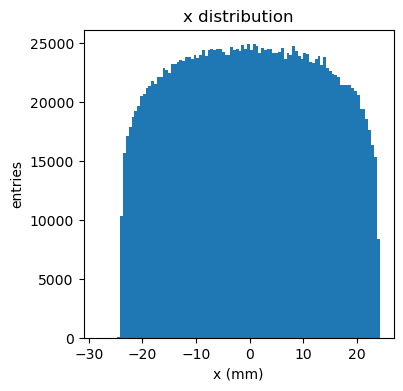

In [22]:
b, e = histoplot(gdf.x, "x (mm)", "entries", bins=100, figsize=(4,4),
                 title="x distribution")

In [23]:
xmin = -np.ceil(-e[0])
xmax = np.ceil(e[-1])
dx = xmax - xmin
print(f"xmax = {xmax:.2f}, xmin = {xmin:.2f}, dx = {dx:.2f}")

xmax = 25.00, xmin = -29.00, dx = 54.00


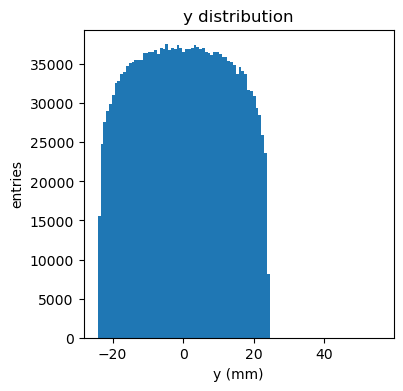

In [24]:
b, e = histoplot(gdf.y, "y (mm)", "entries", bins=100, figsize=(4,4),
                 title="y distribution")

In [25]:
ymin = -np.ceil(-e[0])
ymax = np.ceil(e[-1])
dy = ymax - ymin
print(f"ymax = {ymax:.2f}, ymin = {ymin:.2f}, dy = {dy:.2f}")

ymax = 56.00, ymin = -25.00, dy = 81.00


In [26]:
MCrst = namedtuple('MCrst','xmin xmax dx ymin ymax dy zmin zmax dz')
mcrst = MCrst(xmin, xmax, dx, ymin, ymax, dy, zmin, zmax, dz)
mcrst

MCrst(xmin=-29.0, xmax=25.0, dx=54.0, ymin=-25.0, ymax=56.0, dy=81.0, zmin=-4.0, zmax=70.0, dz=74.0)

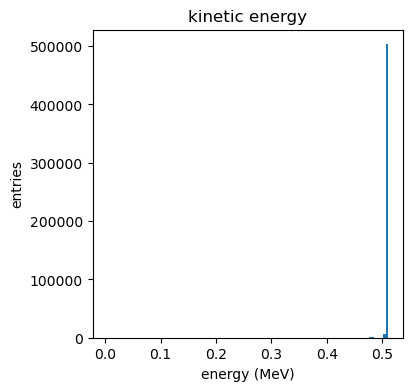

In [27]:
b, e = histoplot(event_ekin(gdf), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="kinetic energy")

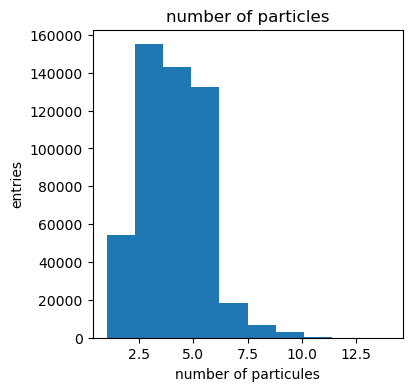

In [28]:
grdf = gdf.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=10, figsize=(4,4,),
                title="number of particles")

## Classification of events

## Select events in which the primary electron makes a photoelectric

In [31]:
grdf = gdf.groupby('event_id')
gpe = grdf.filter(lambda x: ((x.particle_id == 2) & (x['creator_proc'] == 'phot')).any() )
gpe.head(npr)

,event_id,particle_id,particle_name,x,y,z,initial_t,kin_energy,creator_proc
12,680009,4,e-,22.980526,-13.199500,21.642168,0.092036,0.003043,phot
13,680009,3,gamma,22.980526,-13.199500,21.642168,0.092036,0.028609,phot
14,680009,2,e-,22.980526,-13.199500,21.642168,0.092036,0.477824,phot
19,680013,4,e-,7.952593,11.638771,23.469316,0.097319,0.003540,phot
20,680013,3,gamma,7.952593,11.638771,23.469316,0.097319,0.030979,phot
21,680013,2,e-,7.952593,11.638771,23.469316,0.097319,0.475013,phot
22,680014,5,gamma,7.364207,4.223968,32.475761,0.130219,0.004273,phot
23,680014,3,gamma,7.364207,4.223968,32.475761,0.130219,0.030622,phot
24,680014,2,e-,7.364207,4.223968,32.475761,0.130219,0.475013,phot
30,680016,3,gamma,18.515432,11.623202,25.020212,0.104700,0.032294,phot


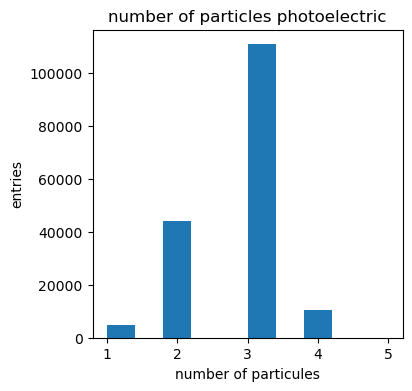

In [32]:
grdf = gpe.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=10, figsize=(4,4),
                title="number of particles photoelectric")

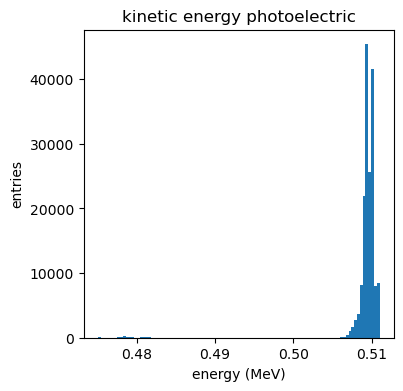

In [33]:
b, e = histoplot(event_ekin(gpe), 'energy (MeV)', "entries", bins=100, figsize=(4,4),
                title="kinetic energy photoelectric")

### Select the electron with energy closest to 0.511 keV
- NB due to Bremms, electron has energies above 0.4778, this value can be used to a cut

In [34]:
fphe = efilter(0.47)

In [35]:
photdf = gpe.groupby('event_id').apply(fphe).reset_index(drop=True)

In [36]:
photdf.head(10)

,event_id,particle_id,particle_name,x,y,z,initial_t,kin_energy,creator_proc
0,10004,2,e-,18.645067,12.477487,29.249544,0.116340,0.477824,phot
1,10006,2,e-,13.566376,1.647984,21.156849,0.090734,0.475013,phot
2,10014,2,e-,-5.014233,5.060986,12.715019,0.062352,0.509922,phot
3,10024,2,e-,-3.514938,-0.639491,15.746504,0.074194,0.475013,phot
4,10026,2,e-,18.973616,-6.031100,16.421364,0.074508,0.475013,phot
5,10027,2,e-,11.437413,-22.155209,40.912632,0.157729,0.505283,phot
6,10028,2,e-,9.708068,3.101629,13.316263,0.064982,0.477824,phot
7,10029,2,e-,0.335767,-11.193620,21.898741,0.093051,0.475013,phot
8,10030,2,e-,16.716444,15.401320,25.922293,0.107143,0.475013,phot
9,10031,2,e-,14.411372,14.232203,48.868683,0.182639,0.475013,phot


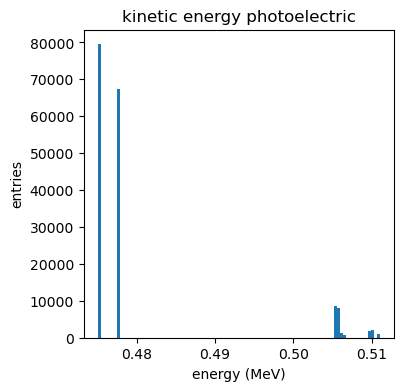

In [37]:
b, e = histoplot(photdf.kin_energy, 'energy (MeV)', "entries", bins=100, figsize=(4,4),
                title="kinetic energy photoelectric")

In [38]:
fphe = event_size(gpe)/event_size(gdf)
print(f"Fraction of photoelectric events = {(fphe):.2f}")

Fraction of photoelectric events = 0.33


In [39]:
fphe2 = event_size(photdf)/event_size(gdf)
print(f"Fraction of photoelectric events passing 1e cut = {(fphe2):.2f}")

Fraction of photoelectric events passing 1e cut = 0.33


## Select Compton

In [29]:
grdf = gdf.groupby('event_id')
gcomp = grdf.filter(lambda x: ((x.particle_id == 2) & (x['creator_proc'] == 'compt')).any() )
gcomp.head(npr)

,event_id,particle_id,particle_name,x,y,z,initial_t,kin_energy,creator_proc
0,680002,2,e-,17.471272,-21.407799,15.194095,0.070294,0.212338,compt
1,680002,25621,e-,16.308014,-8.935721,20.914680,0.116228,0.002909,compt
2,680002,26109,e-,15.823273,-6.602371,22.563520,0.125894,0.003268,phot
3,680002,26108,e-,15.823273,-6.602371,22.563520,0.125894,0.003892,phot
4,680002,26107,e-,15.823273,-6.602371,22.563520,0.125894,0.025294,phot
5,680002,26106,e-,15.823273,-6.602371,22.563520,0.125894,0.258608,phot
6,680005,3,e-,6.790020,7.181014,32.762108,0.128651,0.005044,compt
7,680005,2,e-,6.790020,7.181014,32.762108,0.128651,0.222331,compt
8,680005,27589,e-,15.265637,4.257829,35.750702,0.160174,0.080053,compt
9,680005,37070,e-,18.203693,2.432415,30.927778,0.179971,0.003284,phot


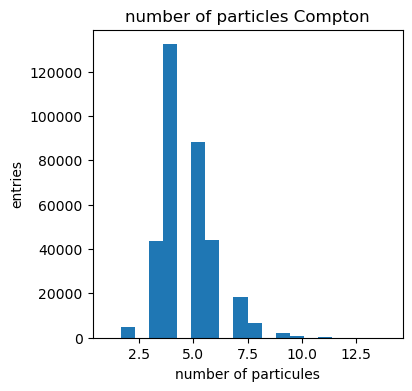

In [30]:
grdf = gcomp.groupby('event_id')
group_sizes = grdf.size()
b, e = histoplot(group_sizes, 'number of particules', "entries", bins=20, figsize=(4,4),
                title="number of particles Compton")

In [31]:
fcomp = event_size(gcomp)/event_size(gdf)
print(f"Fraction of compton events = {(fcomp):.2f}")

Fraction of compton events = 0.66


### Select Comptons whose energy is not near 511.
- A conservative resolution for CsI is 7%, 2sigma = 14%

In [34]:
sigma=0.07
ecut = 0.511 - sigma * 0.511
print(f"cut energy = {ecut}")

cut energy = 0.47523


In [42]:
f4 =efilter(ecut, op="<")

In [43]:
clkpdf = gcomp.groupby('event_id').apply(f4).reset_index(drop=True)

In [44]:
clkpdf.head(10)

,event_id,particle_id,particle_name,x,y,z,initial_t,kin_energy,creator_proc
0,10001,2,e-,-2.954058,-18.557474,22.369658,0.094753,0.116762,compt
1,10001,14135,e-,-5.125206,-7.548854,28.827255,0.137937,0.168832,compt
2,10001,34433,gamma,-5.036511,-9.408172,31.268013,0.148176,0.034926,phot
3,10001,34432,e-,-5.036511,-9.408172,31.268013,0.148176,0.187631,phot
4,10003,2,e-,11.767439,1.126573,13.503364,0.066109,0.179934,compt
5,10003,21595,gamma,4.990294,0.311470,16.939791,0.091601,0.004616,phot
6,10003,21594,gamma,4.990294,0.311470,16.939791,0.091601,0.030622,phot
7,10003,21593,e-,4.990294,0.311470,16.939791,0.091601,0.295061,phot
8,10009,2,e-,9.770208,10.759822,43.035156,0.164733,0.322141,compt
9,10009,39132,e-,12.210072,15.519191,37.142849,0.191277,0.003525,phot


In [45]:
fcomp2 = event_size(clkpdf)/event_size(gdf)
print(f"Fraction of photo-like compton events = {(fcomp2):.2f}")

Fraction of photo-like compton events = 0.66


## Write df for Photoelectric (and photo-like) events

In [47]:
pathpe = os.path.join(dir, "phe.csv")
photdf.to_csv(pathpe, index=False)


### Write images

In [50]:
h5fpfx         = "MonolithicCsI.CsI" # prefix of files
events_per_file = 10000
got_positions = False
crystal_width = 48
sipm_width    = 6
folder_h5     = "CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5" # input h5 folder
    
ifolder = dir
ofolder = os.path.join(path_to_data, get_folder_out(folder_h5) ) 
idf = "phe.csv"

print(f"input folder ={ifolder}, output folder = {ofolder}")
print(f"input DF ={idf}")
  

input folder =/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5, output folder = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe
input DF =phe.csv


In [49]:
if not os.path.exists(ofolder):
    os.makedirs(ofolder)

In [50]:
ifile = os.path.join(ifolder, idf)
ofile = os.path.join(ofolder, idf)
print(f"input file ={ifile}, output file = {ofile}")

input file =/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/phe.csv, output file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/phe.csv


In [51]:
shutil.copy(ifile, ofile)

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/phe.csv'

In [52]:
write_images(photdf, ifolder, ofolder,
             events_per_file, got_positions, crystal_width, sipm_width, h5fpfx)

  0%|                                                                    | 0/100 [00:00<?, ?it/s]

reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.1.h5


  1%|▌                                                           | 1/100 [00:00<01:36,  1.03it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_1.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.2.h5


  2%|█▏                                                          | 2/100 [00:01<01:29,  1.09it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_2.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.3.h5


  3%|█▊                                                          | 3/100 [00:02<01:29,  1.08it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_3.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.4.h5


  4%|██▍                                                         | 4/100 [00:03<01:29,  1.08it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_4.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.5.h5


  5%|███                                                         | 5/100 [00:04<01:26,  1.10it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_5.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.6.h5


  6%|███▌                                                        | 6/100 [00:05<01:24,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_6.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.7.h5


  7%|████▏                                                       | 7/100 [00:06<01:23,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_7.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.8.h5


  8%|████▊                                                       | 8/100 [00:07<01:21,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_8.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.9.h5


  9%|█████▍                                                      | 9/100 [00:08<01:19,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_9.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.10.h5


 10%|█████▉                                                     | 10/100 [00:08<01:18,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_10.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.11.h5


 11%|██████▍                                                    | 11/100 [00:09<01:17,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_11.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.12.h5


 12%|███████                                                    | 12/100 [00:10<01:16,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_12.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.13.h5


 13%|███████▋                                                   | 13/100 [00:11<01:15,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_13.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.14.h5


 14%|████████▎                                                  | 14/100 [00:12<01:15,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_14.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.15.h5


 15%|████████▊                                                  | 15/100 [00:13<01:15,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_15.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.16.h5


 16%|█████████▍                                                 | 16/100 [00:14<01:14,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_16.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.17.h5


 17%|██████████                                                 | 17/100 [00:15<01:13,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_17.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.18.h5


 18%|██████████▌                                                | 18/100 [00:16<01:12,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_18.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.19.h5


 19%|███████████▏                                               | 19/100 [00:16<01:10,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_19.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.20.h5


 20%|███████████▊                                               | 20/100 [00:17<01:10,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_20.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.21.h5


 21%|████████████▍                                              | 21/100 [00:18<01:08,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_21.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.22.h5


 22%|████████████▉                                              | 22/100 [00:19<01:07,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_22.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.23.h5


 23%|█████████████▌                                             | 23/100 [00:20<01:07,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_23.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.24.h5


 24%|██████████████▏                                            | 24/100 [00:21<01:06,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_24.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.25.h5


 25%|██████████████▊                                            | 25/100 [00:22<01:05,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_25.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.26.h5


 26%|███████████████▎                                           | 26/100 [00:22<01:04,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_26.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.27.h5


 27%|███████████████▉                                           | 27/100 [00:23<01:04,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_27.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.28.h5


 28%|████████████████▌                                          | 28/100 [00:24<01:03,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_28.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.29.h5


 29%|█████████████████                                          | 29/100 [00:25<01:02,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_29.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.30.h5


 30%|█████████████████▋                                         | 30/100 [00:26<01:02,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_30.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.31.h5


 31%|██████████████████▎                                        | 31/100 [00:27<01:00,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_31.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.32.h5


 32%|██████████████████▉                                        | 32/100 [00:28<00:59,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_32.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.33.h5


 33%|███████████████████▍                                       | 33/100 [00:29<00:58,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_33.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.34.h5


 34%|████████████████████                                       | 34/100 [00:30<00:57,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_34.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.35.h5


 35%|████████████████████▋                                      | 35/100 [00:30<00:56,  1.16it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_35.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.36.h5


 36%|█████████████████████▏                                     | 36/100 [00:31<00:55,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_36.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.37.h5


 37%|█████████████████████▊                                     | 37/100 [00:32<00:54,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_37.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.38.h5


 38%|██████████████████████▍                                    | 38/100 [00:33<00:54,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_38.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.39.h5


 39%|███████████████████████                                    | 39/100 [00:34<00:52,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_39.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.40.h5


 40%|███████████████████████▌                                   | 40/100 [00:35<00:53,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_40.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.41.h5


 41%|████████████████████████▏                                  | 41/100 [00:36<00:52,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_41.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.42.h5


 42%|████████████████████████▊                                  | 42/100 [00:37<00:52,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_42.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.43.h5


 43%|█████████████████████████▎                                 | 43/100 [00:38<00:51,  1.10it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_43.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.44.h5


 44%|█████████████████████████▉                                 | 44/100 [00:38<00:51,  1.09it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_44.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.45.h5


 45%|██████████████████████████▌                                | 45/100 [00:39<00:49,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_45.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.46.h5


 46%|███████████████████████████▏                               | 46/100 [00:40<00:49,  1.09it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_46.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.47.h5


 47%|███████████████████████████▋                               | 47/100 [00:41<00:48,  1.10it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_47.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.48.h5


 48%|████████████████████████████▎                              | 48/100 [00:42<00:47,  1.10it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_48.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.49.h5


 49%|████████████████████████████▉                              | 49/100 [00:43<00:45,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_49.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.50.h5


 50%|█████████████████████████████▌                             | 50/100 [00:44<00:44,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_50.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.51.h5


 51%|██████████████████████████████                             | 51/100 [00:45<00:43,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_51.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.52.h5


 52%|██████████████████████████████▋                            | 52/100 [00:46<00:43,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_52.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.53.h5


 53%|███████████████████████████████▎                           | 53/100 [00:47<00:42,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_53.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.54.h5


 54%|███████████████████████████████▊                           | 54/100 [00:47<00:41,  1.10it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_54.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.55.h5


 55%|████████████████████████████████▍                          | 55/100 [00:48<00:40,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_55.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.56.h5


 56%|█████████████████████████████████                          | 56/100 [00:49<00:39,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_56.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.57.h5


 57%|█████████████████████████████████▋                         | 57/100 [00:50<00:38,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_57.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.58.h5


 58%|██████████████████████████████████▏                        | 58/100 [00:51<00:37,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_58.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.59.h5


 59%|██████████████████████████████████▊                        | 59/100 [00:52<00:36,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_59.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.60.h5


 60%|███████████████████████████████████▍                       | 60/100 [00:53<00:35,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_60.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.61.h5


 61%|███████████████████████████████████▉                       | 61/100 [00:54<00:34,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_61.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.62.h5


 62%|████████████████████████████████████▌                      | 62/100 [00:55<00:33,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_62.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.63.h5


 63%|█████████████████████████████████████▏                     | 63/100 [00:55<00:32,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_63.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.64.h5


 64%|█████████████████████████████████████▊                     | 64/100 [00:56<00:31,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_64.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.65.h5


 65%|██████████████████████████████████████▎                    | 65/100 [00:57<00:31,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_65.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.66.h5


 66%|██████████████████████████████████████▉                    | 66/100 [00:58<00:30,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_66.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.67.h5


 67%|███████████████████████████████████████▌                   | 67/100 [00:59<00:29,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_67.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.68.h5


 68%|████████████████████████████████████████                   | 68/100 [01:00<00:28,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_68.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.69.h5


 69%|████████████████████████████████████████▋                  | 69/100 [01:01<00:27,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_69.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.70.h5


 70%|█████████████████████████████████████████▎                 | 70/100 [01:02<00:26,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_70.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.71.h5


 71%|█████████████████████████████████████████▉                 | 71/100 [01:03<00:25,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_71.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.72.h5


 72%|██████████████████████████████████████████▍                | 72/100 [01:03<00:25,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_72.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.73.h5


 73%|███████████████████████████████████████████                | 73/100 [01:04<00:24,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_73.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.74.h5


 74%|███████████████████████████████████████████▋               | 74/100 [01:05<00:23,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_74.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.75.h5


 75%|████████████████████████████████████████████▎              | 75/100 [01:06<00:22,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_75.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.76.h5


 76%|████████████████████████████████████████████▊              | 76/100 [01:07<00:21,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_76.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.77.h5


 77%|█████████████████████████████████████████████▍             | 77/100 [01:08<00:20,  1.10it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_77.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.78.h5


 78%|██████████████████████████████████████████████             | 78/100 [01:09<00:19,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_78.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.79.h5


 79%|██████████████████████████████████████████████▌            | 79/100 [01:10<00:18,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_79.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.80.h5


 80%|███████████████████████████████████████████████▏           | 80/100 [01:11<00:17,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_80.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.81.h5


 81%|███████████████████████████████████████████████▊           | 81/100 [01:11<00:16,  1.15it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_81.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.82.h5


 82%|████████████████████████████████████████████████▍          | 82/100 [01:12<00:15,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_82.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.83.h5


 83%|████████████████████████████████████████████████▉          | 83/100 [01:13<00:14,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_83.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.84.h5


 84%|█████████████████████████████████████████████████▌         | 84/100 [01:14<00:14,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_84.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.85.h5


 85%|██████████████████████████████████████████████████▏        | 85/100 [01:15<00:13,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_85.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.86.h5


 86%|██████████████████████████████████████████████████▋        | 86/100 [01:16<00:12,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_86.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.87.h5


 87%|███████████████████████████████████████████████████▎       | 87/100 [01:17<00:11,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_87.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.88.h5


 88%|███████████████████████████████████████████████████▉       | 88/100 [01:18<00:10,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_88.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.89.h5


 89%|████████████████████████████████████████████████████▌      | 89/100 [01:19<00:09,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_89.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.90.h5


 90%|█████████████████████████████████████████████████████      | 90/100 [01:20<00:08,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_90.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.91.h5


 91%|█████████████████████████████████████████████████████▋     | 91/100 [01:20<00:07,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_91.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.92.h5


 92%|██████████████████████████████████████████████████████▎    | 92/100 [01:21<00:07,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_92.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.93.h5


 93%|██████████████████████████████████████████████████████▊    | 93/100 [01:22<00:06,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_93.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.94.h5


 94%|███████████████████████████████████████████████████████▍   | 94/100 [01:23<00:05,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_94.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.95.h5


 95%|████████████████████████████████████████████████████████   | 95/100 [01:24<00:04,  1.12it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_95.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.96.h5


 96%|████████████████████████████████████████████████████████▋  | 96/100 [01:25<00:03,  1.11it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_96.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.97.h5


 97%|█████████████████████████████████████████████████████████▏ | 97/100 [01:26<00:02,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_97.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.98.h5


 98%|█████████████████████████████████████████████████████████▊ | 98/100 [01:27<00:01,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_98.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.99.h5


 99%|██████████████████████████████████████████████████████████▍| 99/100 [01:27<00:00,  1.14it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_99.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.100.h5


100%|██████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_phe/images_100.npy


## Write df for Compton events

In [58]:
idf = "compt.csv"
pathc = os.path.join(dir, idf)
clkpdf.to_csv(pathc, index=False)


In [59]:
ofolder = os.path.join(path_to_data, get_folder_out(folder_h5,lbl="compt") ) 
print(f"input folder ={ifolder}, output folder = {ofolder}")

input folder =/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5, output folder = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt


In [60]:
if not os.path.exists(ofolder):
    os.makedirs(ofolder)

In [61]:
ifile = os.path.join(ifolder, idf)
ofile = os.path.join(ofolder, idf)
print(f"input file ={ifile}, output file = {ofile}")

input file =/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/compt.csv, output file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/compt.csv


In [62]:
shutil.copy(ifile, ofile)

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/compt.csv'

In [63]:
write_images(clkpdf, ifolder, ofolder,
             events_per_file, got_positions, crystal_width, sipm_width, h5fpfx)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.1.h5


  1%|▍                                          | 1/100 [00:02<03:32,  2.15s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_1.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.2.h5


  2%|▊                                          | 2/100 [00:04<03:23,  2.08s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_2.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.3.h5


  3%|█▎                                         | 3/100 [00:06<03:19,  2.06s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_3.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.4.h5


  4%|█▋                                         | 4/100 [00:08<03:17,  2.05s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_4.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.5.h5


  5%|██▏                                        | 5/100 [00:10<03:14,  2.05s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_5.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.6.h5


  6%|██▌                                        | 6/100 [00:12<03:12,  2.05s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_6.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.7.h5


  7%|███                                        | 7/100 [00:14<03:08,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_7.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.8.h5


  8%|███▍                                       | 8/100 [00:16<03:06,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_8.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.9.h5


  9%|███▊                                       | 9/100 [00:18<03:04,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_9.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.10.h5


 10%|████▏                                     | 10/100 [00:20<03:02,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_10.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.11.h5


 11%|████▌                                     | 11/100 [00:22<03:00,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_11.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.12.h5


 12%|█████                                     | 12/100 [00:24<03:00,  2.05s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_12.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.13.h5


 13%|█████▍                                    | 13/100 [00:26<02:58,  2.05s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_13.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.14.h5


 14%|█████▉                                    | 14/100 [00:28<02:55,  2.04s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_14.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.15.h5


 15%|██████▎                                   | 15/100 [00:30<02:51,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_15.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.16.h5


 16%|██████▋                                   | 16/100 [00:32<02:49,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_16.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.17.h5


 17%|███████▏                                  | 17/100 [00:34<02:48,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_17.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.18.h5


 18%|███████▌                                  | 18/100 [00:36<02:47,  2.04s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_18.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.19.h5


 19%|███████▉                                  | 19/100 [00:38<02:45,  2.04s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_19.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.20.h5


 20%|████████▍                                 | 20/100 [00:40<02:43,  2.04s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_20.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.21.h5


 21%|████████▊                                 | 21/100 [00:42<02:41,  2.05s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_21.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.22.h5


 22%|█████████▏                                | 22/100 [00:44<02:39,  2.05s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_22.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.23.h5


 23%|█████████▋                                | 23/100 [00:46<02:38,  2.05s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_23.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.24.h5


 24%|██████████                                | 24/100 [00:49<02:38,  2.09s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_24.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.25.h5


 25%|██████████▌                               | 25/100 [00:51<02:34,  2.06s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_25.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.26.h5


 26%|██████████▉                               | 26/100 [00:53<02:31,  2.05s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_26.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.27.h5


 27%|███████████▎                              | 27/100 [00:55<02:28,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_27.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.28.h5


 28%|███████████▊                              | 28/100 [00:57<02:23,  1.99s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_28.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.29.h5


 29%|████████████▏                             | 29/100 [00:58<02:18,  1.95s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_29.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.30.h5


 30%|████████████▌                             | 30/100 [01:00<02:16,  1.95s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_30.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.31.h5


 31%|█████████████                             | 31/100 [01:02<02:13,  1.93s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_31.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.32.h5


 32%|█████████████▍                            | 32/100 [01:04<02:11,  1.93s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_32.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.33.h5


 33%|█████████████▊                            | 33/100 [01:06<02:09,  1.94s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_33.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.34.h5


 34%|██████████████▎                           | 34/100 [01:08<02:08,  1.94s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_34.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.35.h5


 35%|██████████████▋                           | 35/100 [01:10<02:06,  1.94s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_35.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.36.h5


 36%|███████████████                           | 36/100 [01:12<02:03,  1.93s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_36.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.37.h5


 37%|███████████████▌                          | 37/100 [01:14<02:01,  1.93s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_37.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.38.h5


 38%|███████████████▉                          | 38/100 [01:16<01:58,  1.91s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_38.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.39.h5


 39%|████████████████▍                         | 39/100 [01:17<01:54,  1.87s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_39.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.40.h5


 40%|████████████████▊                         | 40/100 [01:20<01:58,  1.98s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_40.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.41.h5


 41%|█████████████████▏                        | 41/100 [01:22<02:01,  2.07s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_41.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.42.h5


 42%|█████████████████▋                        | 42/100 [01:24<01:57,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_42.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.43.h5


 43%|██████████████████                        | 43/100 [01:26<01:51,  1.96s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_43.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.44.h5


 44%|██████████████████▍                       | 44/100 [01:28<01:47,  1.92s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_44.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.45.h5


 45%|██████████████████▉                       | 45/100 [01:29<01:44,  1.90s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_45.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.46.h5


 46%|███████████████████▎                      | 46/100 [01:32<01:45,  1.96s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_46.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.47.h5


 47%|███████████████████▋                      | 47/100 [01:33<01:43,  1.96s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_47.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.48.h5


 48%|████████████████████▏                     | 48/100 [01:35<01:39,  1.92s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_48.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.49.h5


 49%|████████████████████▌                     | 49/100 [01:37<01:37,  1.91s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_49.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.50.h5


 50%|█████████████████████                     | 50/100 [01:39<01:33,  1.86s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_50.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.51.h5


 51%|█████████████████████▍                    | 51/100 [01:41<01:29,  1.83s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_51.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.52.h5


 52%|█████████████████████▊                    | 52/100 [01:42<01:26,  1.81s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_52.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.53.h5


 53%|██████████████████████▎                   | 53/100 [01:44<01:25,  1.83s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_53.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.54.h5


 54%|██████████████████████▋                   | 54/100 [01:46<01:22,  1.80s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_54.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.55.h5


 55%|███████████████████████                   | 55/100 [01:48<01:21,  1.80s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_55.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.56.h5


 56%|███████████████████████▌                  | 56/100 [01:50<01:22,  1.88s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_56.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.57.h5


 57%|███████████████████████▉                  | 57/100 [01:52<01:20,  1.88s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_57.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.58.h5


 58%|████████████████████████▎                 | 58/100 [01:54<01:19,  1.90s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_58.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.59.h5


 59%|████████████████████████▊                 | 59/100 [01:56<01:20,  1.96s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_59.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.60.h5


 60%|█████████████████████████▏                | 60/100 [01:58<01:18,  1.95s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_60.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.61.h5


 61%|█████████████████████████▌                | 61/100 [02:00<01:16,  1.96s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_61.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.62.h5


 62%|██████████████████████████                | 62/100 [02:02<01:16,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_62.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.63.h5


 63%|██████████████████████████▍               | 63/100 [02:04<01:13,  1.99s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_63.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.64.h5


 64%|██████████████████████████▉               | 64/100 [02:06<01:12,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_64.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.65.h5


 65%|███████████████████████████▎              | 65/100 [02:08<01:10,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_65.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.66.h5


 66%|███████████████████████████▋              | 66/100 [02:10<01:09,  2.04s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_66.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.67.h5


 67%|████████████████████████████▏             | 67/100 [02:12<01:07,  2.04s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_67.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.68.h5


 68%|████████████████████████████▌             | 68/100 [02:14<01:05,  2.04s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_68.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.69.h5


 69%|████████████████████████████▉             | 69/100 [02:16<01:02,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_69.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.70.h5


 70%|█████████████████████████████▍            | 70/100 [02:18<01:01,  2.04s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_70.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.71.h5


 71%|█████████████████████████████▊            | 71/100 [02:20<00:59,  2.06s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_71.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.72.h5


 72%|██████████████████████████████▏           | 72/100 [02:22<00:57,  2.06s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_72.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.73.h5


 73%|██████████████████████████████▋           | 73/100 [02:24<00:55,  2.05s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_73.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.74.h5


 74%|███████████████████████████████           | 74/100 [02:26<00:53,  2.06s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_74.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.75.h5


 75%|███████████████████████████████▌          | 75/100 [02:28<00:51,  2.05s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_75.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.76.h5


 76%|███████████████████████████████▉          | 76/100 [02:31<00:49,  2.04s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_76.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.77.h5


 77%|████████████████████████████████▎         | 77/100 [02:33<00:46,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_77.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.78.h5


 78%|████████████████████████████████▊         | 78/100 [02:35<00:44,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_78.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.79.h5


 79%|█████████████████████████████████▏        | 79/100 [02:37<00:43,  2.06s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_79.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.80.h5


 80%|█████████████████████████████████▌        | 80/100 [02:39<00:41,  2.06s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_80.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.81.h5


 81%|██████████████████████████████████        | 81/100 [02:41<00:39,  2.06s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_81.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.82.h5


 82%|██████████████████████████████████▍       | 82/100 [02:43<00:36,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_82.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.83.h5


 83%|██████████████████████████████████▊       | 83/100 [02:45<00:34,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_83.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.84.h5


 84%|███████████████████████████████████▎      | 84/100 [02:47<00:32,  2.01s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_84.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.85.h5


 85%|███████████████████████████████████▋      | 85/100 [02:49<00:30,  2.01s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_85.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.86.h5


 86%|████████████████████████████████████      | 86/100 [02:51<00:28,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_86.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.87.h5


 87%|████████████████████████████████████▌     | 87/100 [02:53<00:26,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_87.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.88.h5


 88%|████████████████████████████████████▉     | 88/100 [02:55<00:24,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_88.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.89.h5


 89%|█████████████████████████████████████▍    | 89/100 [02:57<00:22,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_89.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.90.h5


 90%|█████████████████████████████████████▊    | 90/100 [02:59<00:20,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_90.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.91.h5


 91%|██████████████████████████████████████▏   | 91/100 [03:01<00:18,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_91.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.92.h5


 92%|██████████████████████████████████████▋   | 92/100 [03:03<00:16,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_92.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.93.h5


 93%|███████████████████████████████████████   | 93/100 [03:05<00:14,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_93.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.94.h5


 94%|███████████████████████████████████████▍  | 94/100 [03:07<00:12,  2.02s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_94.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.95.h5


 95%|███████████████████████████████████████▉  | 95/100 [03:09<00:10,  2.03s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_95.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.96.h5


 96%|████████████████████████████████████████▎ | 96/100 [03:11<00:08,  2.04s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_96.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.97.h5


 97%|████████████████████████████████████████▋ | 97/100 [03:13<00:06,  2.04s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_97.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.98.h5


 98%|█████████████████████████████████████████▏| 98/100 [03:15<00:04,  2.06s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_98.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.99.h5


 99%|█████████████████████████████████████████▌| 99/100 [03:17<00:02,  2.06s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_99.npy
reading nexus file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_h5/MonolithicCsI.CsI.100.h5


100%|█████████████████████████████████████████| 100/100 [03:19<00:00,  2.00s/it]

saving file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_compt/images_100.npy
